In [37]:
# !pip install numpy
# !pip install matplotlib
# Basic setup: imports and define helper functions
import asyncio, asyncssh, sys, time
import numpy as np
import matplotlib.pyplot as plt

ssh_connections = {}
%store -r

async def start_connection(hostname):
    if hostname not in ssh_connections:
        ssh_connections[hostname] = await asyncssh.connect(hostname, known_hosts=None)
    return ssh_connections[hostname]

async def run_command(hostname, command):
    conn = await start_connection(hostname)
    return (await conn.create_process(command))

async def run_server(hostname):
    return (await run_command(hostname, '/mydata/localuser/frida/server/server'))

async def run_client(hostname, device_id, duration = 10, keepout = 1, datasize = 32, server="http://node0:8080"):
    return (await run_command(hostname, '/mydata/localuser/frida/experiments/throughput_bench/client {} {} {} {} {}'.format(device_id, duration,keepout,datasize,server)))

async def clear_server_storage(hostname):
    await run_command(hostname, "rm -r ~/storage")

async def kill_server(hostname):
    await run_command(hostname, "pkill server")
    
def parse_throughput(tstr):
    return float(tstr.split(",")[1])


In [33]:
throughputs

[37.0,
 46.566666000000005,
 51.733332000000004,
 53.766665,
 58.30000150000001,
 60.266666400000005,
 60.80000300000001,
 62.80000080000001,
 64.26666559999998,
 65.20000030000001]

In [25]:
# Run server for 10 seconds and then quit it, as a demo
server_task = await run_server("node0")
# time.sleep(10)
# server_task.terminate()

In [26]:
server_task = await run_server("node0")
client_task = await run_client("node1", "abcd")
# print(await client_task.stdout.read()) # TODO this blocks indefinitely
# time.sleep(15)
client_task.terminate()
server_task.terminate()
await run_command("node0", "rm -r ~/storage")

In [38]:
num_nodes = 2
duration = 20
keepout = 5
throughputs = []
data_size = 32
max_num_clients_per_node = 16
step_size = 1
for num_clients_per_node in range(1, max_num_clients_per_node + 1, step_size):
    server_task = await run_server("node0")
    time.sleep(10)
    ctasks = []
    num_clients = num_nodes * num_clients_per_node
    for node in range(1, num_nodes + 1):
        for client in range(num_clients_per_node):
            ctask = await run_client("node{}".format(node), "exp_C{}_node{}_id{}".format(num_clients, node, client), duration, keepout, data_size)
            ctasks.append(ctask)
    local_throughputs = []
    time.sleep(duration)
    for ctask in ctasks:
        coutput = await ctask.stdout.read()
#         print(coutput)
        local_throughputs.append(parse_throughput(coutput))
        ctask.terminate()
        
    throughput = sum(local_throughputs)
    print("#Nodes={}, #Clients={}, Throughput = {}/s".format(num_nodes, num_clients, throughput))
    throughputs.append(throughput)
    server_task.terminate()
    await clear_server_storage("node0")

%store throughputs
%store num_nodes
%store keepout
%store data_size
%store max_num_clients_per_node

#Nodes=2, #Clients=2, Throughput = 157.3/s
#Nodes=2, #Clients=4, Throughput = 159.29999999999998/s
#Nodes=2, #Clients=6, Throughput = 159.6/s
#Nodes=2, #Clients=8, Throughput = 159.20000000000002/s
#Nodes=2, #Clients=10, Throughput = 157.1/s
#Nodes=2, #Clients=12, Throughput = 158.5/s
#Nodes=2, #Clients=14, Throughput = 159.60000000000005/s
#Nodes=2, #Clients=16, Throughput = 158.9/s
#Nodes=2, #Clients=18, Throughput = 158.90000000000003/s


IndexError: list index out of range

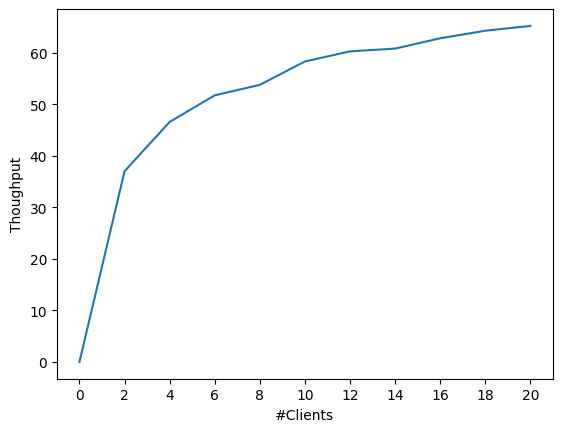

In [17]:

plt.plot([2*t for t in range(len(throughputs)+1)], [0]+throughputs)
plt.xticks(np.arange(0,22, step = 2.0))
plt.xlabel("#Clients")
plt.ylabel("Thoughput")
plt.show()


In [28]:
await clear_server_storage("node0")
await kill_server("node0")